# calc smt natl mixed layer depth

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
#import pyicon as pyic
import cartopy.crs as ccrs
import glob, os
import xarray as xr
import pandas as pd
import cartopy
ccrs_proj = ccrs.PlateCarree()

In [2]:
import pyicon as pyic

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots


In [3]:
import gsw
from icon_smt_levels import dzw, dzt, depthc, depthi

In [4]:
#cluster
import dask
import datetime
import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
#from distributed.utils import tmpfile
#dask.config.set({"distributed.comm.timeouts.tcp": "50s"})

/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
## Start cluster

!echo $HOSTNAME

l10648.atos.local


In [7]:
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'compute' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "35GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [9]:
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "200GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [8]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [9]:
dask_tmp_dir.name

'/scratch/m/m300878/PostProcrh3d6dvo'

In [10]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=35G
#SBATCH -t 8:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/m/m300878/PostProcrh3d6dvo
#SBATCH --begin=now
#SBATCH --output=/scratch/m/m300878/PostProcrh3d6dvo/LOG_cluster.%j.o
#SBATCH --output=/scratch/m/m300878/PostProcrh3d6dvo/LOG_cluster.%j.o

/home/m/m300878/miniconda3/envs/pyicon_py39/bin/python -m distributed.cli.dask_worker tcp://136.172.114.77:34393 --nthreads 4 --nprocs 6 --memory-limit 5.83GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/m/m300878/PostProcrh3d6dvo --interface ib0 --protocol tcp://



In [11]:
cluster.scale(jobs=12)
cluster

In [13]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
            511423   compute PostProc  m300878  R       1:48      1 l40448
            511424   compute PostProc  m300878  R       1:48      1 l10649
            511425   compute PostProc  m300878  R       1:48      1 l20349
            511426   compute PostProc  m300878  R       1:48      1 l20449
            511427   compute PostProc  m300878  R       1:48      1 l20549
            511428   compute PostProc  m300878  R       1:48      1 l30149
            511429   compute PostProc  m300878  R       1:48      1 l30648
            511430   compute PostProc  m300878  R       1:48      1 l40449
            511431   compute PostProc  m300878  R       1:48      1 l10550
            511420   compute PostProc  m300878  R       1:51      1 l20448
            511421   compute PostProc  m300878  R       1:51      1 l20548
            511422   compute PostProc  m300878  R       1:51      1 l30148
            511

In [14]:
client = Client(cluster)
client

<Client: 'tcp://136.172.114.77:34393' processes=72 threads=288, memory=419.76 GiB>

cluster.close()
client.close()

## load smt data

run      = 'ngSMT_tke'
gname = 'smt'
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'

path_grid        = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree     = f'{path_grid}ckdtree/'
fpath_ckdtree    = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

month = '01'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
search_str = f'_T_S_sp_001-016_2010*.nc' 
flist1      = np.array(glob.glob(path_data+search_str))
flist1.sort()
month = '02'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
search_str = f'_T_S_sp_001-016_2010*.nc' 
flist2      = np.array(glob.glob(path_data+search_str))
flist2.sort()
month = '03'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
search_str = f'_T_S_sp_001-016_2010*.nc' 
flist3      = np.array(glob.glob(path_data+search_str))
flist3.sort()

flist = [*flist1, *flist2, *flist3]
flist.sort()

flist_to = flist

In [17]:
layers  =   'sp_001-016' , 'sp_017-032',  'sp_033-048',  'sp_049-064',  'sp_065-080',  'sp_081-096',  'sp_097-112'
tt = 'a','b','c','d','e','f','g'
run      = 'ngSMT_tke'
gname = 'smt'
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'

path_grid        = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree     = f'{path_grid}ckdtree/'
fpath_ckdtree    = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

ii = 0
for ll in enumerate(layers):
    ii += 1
    month = '01'
    path_data = f'/work/mh0287/from_Mistral/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
    search_str = f'_T_S_{ll[1]}_2010*.nc' 
    flist1      = np.array(glob.glob(path_data+search_str))
    flist1.sort()
    month = '02'
    #path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
    path_data = f'/work/mh0287/from_Mistral/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
    flist2      = np.array(glob.glob(path_data+search_str))
    flist2.sort()
    month = '03'
    path_data = f'/work/mh0287/from_Mistral/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
    flist3      = np.array(glob.glob(path_data+search_str))
    flist3.sort()

    flist = [*flist1, *flist2, *flist3]
    flist.sort()
    
    globals()[f"{tt[ii-1]}"] = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1))

to = xr.merge([a,b,c,d,e,f,g])

<xarray.Dataset>
Dimensions:  (time: 984, ncells: 59799625)
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
Dimensions without coordinates: ncells
Data variables: (12/224)
    T001_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S001_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T002_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S002_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T003_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S003_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    ...       ...
    T110_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S110_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T111_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S111_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    T112_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
    S112_sp  (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20180 (Linux 2.6....

In [20]:
fpath_tgrid  = '/home/m/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()

In [21]:
time0 = np.datetime64('2010-01-09T01:00:00')
dti = pd.date_range(time0, periods=984, freq="2h")
to = to.assign_coords(time=dti)
to = to.assign_coords({"clon": ("ncells", clon)})
to = to.assign_coords({"clat": ("ncells", clat)})

In [29]:
#select only temperature data
Tlist = np.empty(depthc.size, dtype='object')
for d in range(depthc.size):
        level = "{0:03}".format(d+1) 
        Tlist[d]= f'T{level}_sp'
Slist = np.empty(depthc.size, dtype='object')
for d in range(depthc.size):
        level = "{0:03}".format(d+1) 
        Slist[d]= f'S{level}_sp'
# drop salinity information
#to = to[Tlist]
#to

In [71]:
lis = np.empty(2*depthc.size, dtype='object')#
k=0
for ii in range(112):
    lis[ii+k]   = Tlist[ii]
    lis[ii+1+k] = Slist[ii]
    k += 1
lis

array(['T001_sp', 'S001_sp', 'T002_sp', 'S002_sp', 'T003_sp', 'S003_sp',
       'T004_sp', 'S004_sp', 'T005_sp', 'S005_sp', 'T006_sp', 'S006_sp',
       'T007_sp', 'S007_sp', 'T008_sp', 'S008_sp', 'T009_sp', 'S009_sp',
       'T010_sp', 'S010_sp', 'T011_sp', 'S011_sp', 'T012_sp', 'S012_sp',
       'T013_sp', 'S013_sp', 'T014_sp', 'S014_sp', 'T015_sp', 'S015_sp',
       'T016_sp', 'S016_sp', 'T017_sp', 'S017_sp', 'T018_sp', 'S018_sp',
       'T019_sp', 'S019_sp', 'T020_sp', 'S020_sp', 'T021_sp', 'S021_sp',
       'T022_sp', 'S022_sp', 'T023_sp', 'S023_sp', 'T024_sp', 'S024_sp',
       'T025_sp', 'S025_sp', 'T026_sp', 'S026_sp', 'T027_sp', 'S027_sp',
       'T028_sp', 'S028_sp', 'T029_sp', 'S029_sp', 'T030_sp', 'S030_sp',
       'T031_sp', 'S031_sp', 'T032_sp', 'S032_sp', 'T033_sp', 'S033_sp',
       'T034_sp', 'S034_sp', 'T035_sp', 'S035_sp', 'T036_sp', 'S036_sp',
       'T037_sp', 'S037_sp', 'T038_sp', 'S038_sp', 'T039_sp', 'S039_sp',
       'T040_sp', 'S040_sp', 'T041_sp', 'S041_sp', 

## calc section indices

In [82]:
npoints = 700

sname         = 'A'
tgname        = 'SMT'
gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
fname_tgrid   = f'{gname}.nc'
path_scratch  = f'/scratch/m/m300878/tmp/'
path_ckdtree  = path_scratch # where grid is stored

#lon = -80.5, -30
lon = -90, 0
#lat = 31.9, 31.9
#lat = 35, 35
lat = 38, 38

dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = pyic.ckdtree_section(p1=[lon[1],lat[0]], p2=[lon[0],lat[0]], npoints=npoints,
                      fname_tgrid  = fname_tgrid,
                      path_tgrid   = path_tgrid,
                      path_ckdtree = path_ckdtree,
                      sname = sname,
                      gname = gname,
                      tgname = tgname,
                      load_egrid=False,
                      load_vgrid=False,
                      )

Saving grid file: /scratch/m/m300878/tmp/SMT_nps700_0E38N_90W38N.nc


# example for instantaneous field

In [52]:
to1 = to.isel(time=750)
to1

<xarray.Dataset>
Dimensions:  (ncells: 59799625)
Coordinates:
    time     datetime64[ns] 2010-03-12T13:00:00
    clon     (ncells) float64 -54.21 -54.22 -54.22 ... -71.82 -71.8 -71.82
    clat     (ncells) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: ncells
Data variables: (12/112)
    T001_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T002_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T003_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T004_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T005_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T006_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    ...       ...
    T107_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T108_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T109_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T110_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T111_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
    T112_sp  (ncells) float32 dask.array<chunksize=(59799625,), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20180 (Linux 2.6....

In [53]:
to1 = to1.isel(ncells=ickdtree)
to1

<xarray.Dataset>
Dimensions:  (ncells: 500)
Coordinates:
    time     datetime64[ns] 2010-03-12T13:00:00
    clon     (ncells) float64 -30.0 -30.1 -30.2 -30.31 ... -80.29 -80.4 -80.5
    clat     (ncells) float64 31.9 31.9 31.9 31.9 31.9 ... 31.9 31.9 31.9 31.9
Dimensions without coordinates: ncells
Data variables: (12/112)
    T001_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T002_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T003_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T004_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T005_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T006_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    ...       ...
    T107_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T108_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T109_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T110_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T111_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    T112_sp  (ncells) float32 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20180 (Linux 2.6....

In [23]:
mld_sec = np.zeros(lon_sec.size)

In [24]:
# MLD by Levitus % should be interpolated to cell surface
#' Spall et al. [2000], North Atlantic ind DT =0.5C 0 m arbitrary'
t_surf = to1.T001_sp.data

for ii in np.arange(mld_sec.size):
    for d in range(depthc.size):
        level = "{0:03}".format(d+1) 
        tdeep = to1.variables[f'T{level}_sp'].isel(ncells=ii)
        tdiff = np.sqrt((t_surf[ii] - tdeep)**2)
        if tdiff >= 0.5:
            print('Mixed Layer depth is', depthc[d])
            break

Mixed Layer depth is 178.75
Mixed Layer depth is 150.25
Mixed Layer depth is 48.5
Mixed Layer depth is 57.5
Mixed Layer depth is 150.25


KeyboardInterrupt: 

In [25]:
tdiff = np.zeros((depthc.size, mld_sec.size))
t_surf = to1.T001_sp.data
for d in range(depthc.size):
        level = "{0:03}".format(d+1) 
        tdeep = to1.variables[f'T{level}_sp']
        tdiff[d,:] = np.sqrt((t_surf - tdeep)**2)

/tmp/ipykernel_1571527/548178111.py:5: UserWarning: The following kwargs were not used by contour: 'interpolation'
  CS = plt.contour(lon_sec, depthc, tdiff, levels,  colors='r',interpolation='none')


Text(0, 0.5, 'depth')

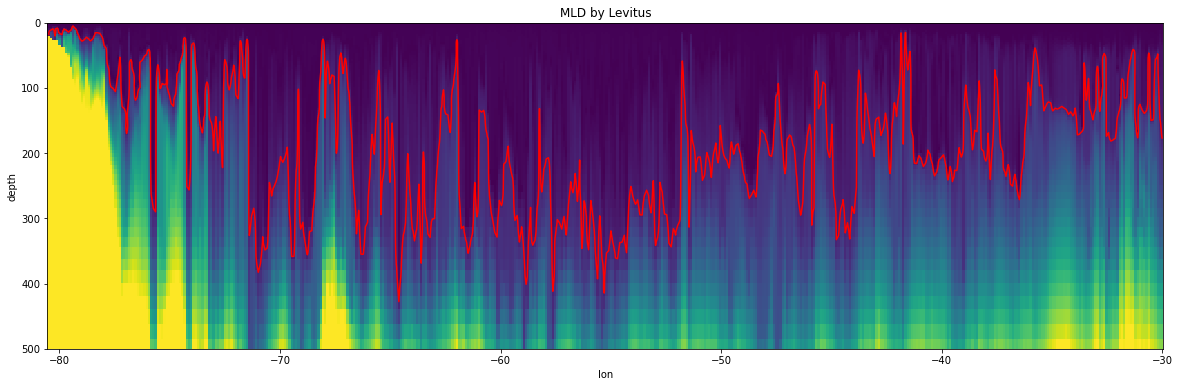

In [32]:
fig = plt.figure(figsize=(20,6))
clim = 0, 10
plt.pcolormesh(lon_sec, depthc, tdiff, vmin = 0, vmax=5)
levels=[0.5, 100]
CS = plt.contour(lon_sec, depthc, tdiff, levels,  colors='r',interpolation='none')
#plt.colorbar()
plt.title('MLD by Levitus')
plt.gca().invert_yaxis()
plt.ylim(500, 0)
plt.xlabel('lon')
plt.ylabel('depth')

# Average Mixed layer depth for each month

In [83]:
to_time = to.isel(ncells= ickdtree)


%%time
t_surf_mean = to_time.T001_sp.resample(time="1M").mean(dim="time")
t_surf_mean = t_surf_mean.compute()

In [84]:
%%time
to_time_mean = to_time.resample(time="1M").mean(dim="time")
#to_time_mean = to_time_mean[Tlist[:81]] # only temperature
to_time_mean = to_time_mean[lis[:162]]
to_time_mean

CPU times: user 3.1 s, sys: 47.7 ms, total: 3.15 s
Wall time: 3.14 s


<xarray.Dataset>
Dimensions:  (time: 3, ncells: 700)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 2010-03-31
    clon     (ncells) float64 0.014 -0.1233 -0.2601 ... -88.0 -88.0 -88.0
    clat     (ncells) float64 38.0 37.99 37.99 38.0 ... 30.72 30.72 30.72 30.72
Dimensions without coordinates: ncells
Data variables: (12/162)
    T001_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    S001_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    T002_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    S002_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    T003_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    S003_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    ...       ...
    T079_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    S079_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    T080_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    S080_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    T081_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>
    S081_sp  (time, ncells) float32 dask.array<chunksize=(1, 700), meta=np.ndarray>

In [85]:
%%time
to_time_mean = to_time_mean.compute()
to_time_mean.to_netcdf('/work/mh0033/m300878/model_evaluation/mld/smt/toso_section_38_mean.nc')

CPU times: user 22min 32s, sys: 20.8 s, total: 22min 52s
Wall time: 32min 43s


------------

In [41]:
tdiff = np.zeros((81, 3, ickdtree.size))

for d in range(81):
        level = "{0:03}".format(d+1) 
        tdeep = to_time_mean.variables[f'T{level}_sp']
        tdiff[d,:,:] = np.sqrt((t_surf_mean - tdeep)**2)

In [42]:
d

80

In [256]:
np.save('data/tdiff', tdiff)

In [47]:
fig = plt.figure(figsize=(20,6))
clim = 0, 10
plt.pcolormesh(lon_sec, depthc[:81], tdiff[:,0,:], vmin = 0, vmax=5)
levels=[0.5, 100]
CS = plt.contour(lon_sec, depthc[:81], tdiff[:,0,:], levels,  colors='r',interpolation='none')
CS = plt.contour(lon_sec, depthc[:81], tdiff[:,1,:], levels,  colors='r',interpolation='none')
CS = plt.contour(lon_sec, depthc[:81], tdiff[:,2,:], levels,  colors='r',interpolation='none')
#CS = plt.contour(lon_sec, depthc, tdiff, levels,  colors='r',interpolation='none')
#plt.colorbar()
plt.title('MLD by Levitus')
plt.gca().invert_yaxis()
plt.ylim(500, 0)
plt.xlabel('lon')
plt.ylabel('depth')

/tmp/ipykernel_1572796/3913437529.py:5: UserWarning: The following kwargs were not used by contour: 'interpolation'
  CS = plt.contour(lon_sec, depthc[:81], tdiff[:,0,:], levels,  colors='r',interpolation='none')
/tmp/ipykernel_1572796/3913437529.py:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  CS = plt.contour(lon_sec, depthc[:81], tdiff[:,1,:], levels,  colors='r',interpolation='none')
/tmp/ipykernel_1572796/3913437529.py:7: UserWarning: The following kwargs were not used by contour: 'interpolation'
  CS = plt.contour(lon_sec, depthc[:81], tdiff[:,2,:], levels,  colors='r',interpolation='none')


Text(0, 0.5, 'depth')

In [215]:
td = 'a'
for d in range(depthc.size):
        level = "{0:03}".format(d+1) 
        td = td + f'T{level}_sp'
td

'aT001_spT002_spT003_spT004_spT005_spT006_spT007_spT008_spT009_spT010_spT011_spT012_spT013_spT014_spT015_spT016_spT017_spT018_spT019_spT020_spT021_spT022_spT023_spT024_spT025_spT026_spT027_spT028_spT029_spT030_spT031_spT032_spT033_spT034_spT035_spT036_spT037_spT038_spT039_spT040_spT041_spT042_spT043_spT044_spT045_spT046_spT047_spT048_spT049_spT050_spT051_spT052_spT053_spT054_spT055_spT056_spT057_spT058_spT059_spT060_spT061_spT062_spT063_spT064_spT065_spT066_spT067_spT068_spT069_spT070_spT071_spT072_spT073_spT074_spT075_spT076_spT077_spT078_spT079_spT080_spT081_spT082_spT083_spT084_spT085_spT086_spT087_spT088_spT089_spT090_spT091_spT092_spT093_spT094_spT095_spT096_spT097_spT098_spT099_spT100_spT101_spT102_spT103_spT104_spT105_spT106_spT107_spT108_spT109_spT110_spT111_spT112_sp'

In [211]:
to_time.variables[td]

<xarray.Variable (time: 984, ncells: 500)>
dask.array<getitem, shape=(984, 500), dtype=float32, chunksize=(1, 500), chunktype=numpy.ndarray>
Attributes:
    standard_name:                temperature at level 112
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [ ]:
rhop   = gsw.rho(so[lev,:], to[lev,:], depthc[lev]) # choice of depthi interpolates rho to desired depth


client.close()
cluster.close()